###**ATOC4500 Data Science Lab: Final Project**
###**Determining the Validity of Clustering Seasons for Denver, Colorado Using Daily Mean AQI Data**
###Author: Erica Bortfeldt, erica.bortfeldt@colorado.edu###
###last updated: April 27, 2022###

**>>>> This code is available on github at https://github.com/eri-bortfeldt/ATOC4500_BORTFELDT_FinalProject**

###**Introduction:** This project seeks to determine whether or not daily mean AQI measurements are a valid variable to use for clustering seasons in Denver, CO. I have one primary research question that addresses the scientific goal: Can daily measurements of Air Quality Index be factored into a cluster analysis for seasons in Denver, Colorado in the same way daily measurements of temperature and/or precipitation can be used for the same purpose? My working hypothesis is that daily measurements of AQI can be factored into a cluster analysis for seasons in Denver, Colorado, but perhaps with not the same level of accuracy or reliability as with just daily measurements of temperature and precipitation, because AQI is not as strongly seasonally-variable as other meteorological variables.



###**Step 1: Read in data**



The dataset used in this project was manually constructed by me; I compiled together Denver Int'l Airport 2016-2020 data for Daily Mean AQI and Daily Mean PM2.5 Concentration from the EPA website and did the same for max/min temp, precip and snowfall from 2016-2020 from CSU's Colorado Climate Center archives. I then calculated a column for 'total precip' which adds the precip and snowfall columns together.

In [1]:
import pandas as pd
import numpy as np
import datetime
from google.colab import files

from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.pyplot as plt

In [3]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving 2016_2020dailyAQIMETDENfinal(1).csv to 2016_2020dailyAQIMETDENfinal(1) (1).csv
User uploaded file "2016_2020dailyAQIMETDENfinal(1).csv" with length 55261 bytes


In [4]:
df = pd.read_csv("2016_2020dailyAQIMETDENfinal(1).csv") 

print(df) 
 
print(df.shape)

            Date Max Temp  Min Temp  Precip (in.)  Snowfall (in.)  \
0       1/1/2016       35         6          0.00             0.0   
1       1/2/2016       41        16          0.00             0.0   
2       1/3/2016       46        15          0.00             0.0   
3       1/4/2016       45        18          0.00             0.0   
4       1/5/2016       45        23          0.00             0.0   
...          ...      ...       ...           ...             ...   
1766  12/27/2020       46        26          0.00             0.0   
1767  12/28/2020       30        25          0.16             1.9   
1768  12/29/2020       33        15          0.00             0.0   
1769  12/30/2020       44         7          0.00             0.0   
1770  12/31/2020       43        19          0.00             0.0   

      Total Precip (in.)  Daily Mean AQI  Daily Mean PM2.5 (ug/m^3)  
0                   0.00              51                       12.3  
1                   0.00       

In [6]:
df.Date

0         1/1/2016
1         1/2/2016
2         1/3/2016
3         1/4/2016
4         1/5/2016
           ...    
1766    12/27/2020
1767    12/28/2020
1768    12/29/2020
1769    12/30/2020
1770    12/31/2020
Name: Date, Length: 1771, dtype: object

In [7]:
df.columns

Index(['Date', 'Max Temp', 'Min Temp', 'Precip (in.)', 'Snowfall (in.)',
       'Total Precip (in.)', 'Daily Mean AQI', 'Daily Mean PM2.5 (ug/m^3)'],
      dtype='object')

###**Step 2: Munge data**

Two datasets were manually compiled into one .csv file; the first dataset, acquired from the EPA Outdoor Air Quality website, included daily mean PM2.5 concentration and daily mean AQI for every day of 2016-2020. The second dataset, acquired from the Colorado Climate Center at CSU, included daily measurements of maximum temperature, minimum temperature, daily precipitation, and daily snowfall for every day of 2016-2020. The new .csv file compiled from these two datasets was also manually stripped of all dates missing any data and includes an additional column where *total* daily precipitation was calculated for all dates. Below includes the final munging process - sorting columns into months in order to designate data into season clusters.

In [8]:
df

,Date,Max Temp,Min Temp,Precip (in.),Snowfall (in.),Total Precip (in.),Daily Mean AQI,Daily Mean PM2.5 (ug/m^3)
0,1/1/2016,35,6,0.00,0.0,0.00,51,12.3
1,1/2/2016,41,16,0.00,0.0,0.00,21,5.1
2,1/3/2016,46,15,0.00,0.0,0.00,57,14.8
3,1/4/2016,45,18,0.00,0.0,0.00,83,27.4
4,1/5/2016,45,23,0.00,0.0,0.00,59,15.9
...,...,...,...,...,...,...,...,...
1766,12/27/2020,46,26,0.00,0.0,0.00,5,1.3
1767,12/28/2020,30,25,0.16,1.9,2.06,30,7.1
1768,12/29/2020,33,15,0.00,0.0,0.00,48,11.5
1769,12/30/2020,44,7,0.00,0.0,0.00,32,7.6


In [9]:
### add a new variable to the dataframe that has the date in a "datetime" variable that python knows
from datetime import date
import datetime

##create a datetime object from a string
#foo = datetime.strptime('2012-01-01', '%Y-%m-%d')
#foo = datetime.strptime('2012-01-01T00:53:00', '%Y-%m-%dT%H:%M:%S')
#foo = datetime.strptime(df['DATE'][0], '%Y-%m-%dT%H:%M:%S')
#print(foo)

## look at the format of the date in the data
df['Date']

## play with converting something similar to the date in the data into a datetime
foo='1/1/2016'
print(foo)
print(pd.to_datetime(foo, format='%m/%d/%Y'))
print('YEA!!!! THIS WORKS :)!!!')

## try it on all data
#print(pd.to_datetime(df['Date'], format='%m/%d/%Y'))
#print('YEA!!!! THIS WORKS but i won't print it every time :)!!!')

df['datetime'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df

1/1/2016
2016-01-01 00:00:00
YEA!!!! THIS WORKS :)!!!


,Date,Max Temp,Min Temp,Precip (in.),Snowfall (in.),Total Precip (in.),Daily Mean AQI,Daily Mean PM2.5 (ug/m^3),datetime
0,1/1/2016,35,6,0.00,0.0,0.00,51,12.3,2016-01-01
1,1/2/2016,41,16,0.00,0.0,0.00,21,5.1,2016-01-02
2,1/3/2016,46,15,0.00,0.0,0.00,57,14.8,2016-01-03
3,1/4/2016,45,18,0.00,0.0,0.00,83,27.4,2016-01-04
4,1/5/2016,45,23,0.00,0.0,0.00,59,15.9,2016-01-05
...,...,...,...,...,...,...,...,...,...
1766,12/27/2020,46,26,0.00,0.0,0.00,5,1.3,2020-12-27
1767,12/28/2020,30,25,0.16,1.9,2.06,30,7.1,2020-12-28
1768,12/29/2020,33,15,0.00,0.0,0.00,48,11.5,2020-12-29
1769,12/30/2020,44,7,0.00,0.0,0.00,32,7.6,2020-12-30


In [10]:
## strip out the month from the datetime object

df['month'] = df.datetime.dt.strftime('%m')

df

,Date,Max Temp,Min Temp,Precip (in.),Snowfall (in.),Total Precip (in.),Daily Mean AQI,Daily Mean PM2.5 (ug/m^3),datetime,month
0,1/1/2016,35,6,0.00,0.0,0.00,51,12.3,2016-01-01,01
1,1/2/2016,41,16,0.00,0.0,0.00,21,5.1,2016-01-02,01
2,1/3/2016,46,15,0.00,0.0,0.00,57,14.8,2016-01-03,01
3,1/4/2016,45,18,0.00,0.0,0.00,83,27.4,2016-01-04,01
4,1/5/2016,45,23,0.00,0.0,0.00,59,15.9,2016-01-05,01
...,...,...,...,...,...,...,...,...,...,...
1766,12/27/2020,46,26,0.00,0.0,0.00,5,1.3,2020-12-27,12
1767,12/28/2020,30,25,0.16,1.9,2.06,30,7.1,2020-12-28,12
1768,12/29/2020,33,15,0.00,0.0,0.00,48,11.5,2020-12-29,12
1769,12/30/2020,44,7,0.00,0.0,0.00,32,7.6,2020-12-30,12


###**Step 3: Apply Data Science Method(s)**

In this step, I define month numbers for each season and create a new variable for seasons. I then define columns/variables of interest for my cluster analysis; this is done for Daily Mean AQI and Daily Mean PM 2.5. Afterwards, I create some plots to visualize the data in a few different timeseries. Lastly, I define the amount of clusters I want. In this case, it's 4. 

In [11]:
# define month numbers for each season 
seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4} 
# assign season to each month 
def season(ser): 
 for k in seasons.keys(): 
  if ser in k: 
    return seasons[k] 
# create new season variable 
df['season']=[season(month) for month in pd.DatetimeIndex(df['Date']).month] 
# new dataframe 
df 

,Date,Max Temp,Min Temp,Precip (in.),Snowfall (in.),Total Precip (in.),Daily Mean AQI,Daily Mean PM2.5 (ug/m^3),datetime,month,season
0,1/1/2016,35,6,0.00,0.0,0.00,51,12.3,2016-01-01,01,1
1,1/2/2016,41,16,0.00,0.0,0.00,21,5.1,2016-01-02,01,1
2,1/3/2016,46,15,0.00,0.0,0.00,57,14.8,2016-01-03,01,1
3,1/4/2016,45,18,0.00,0.0,0.00,83,27.4,2016-01-04,01,1
4,1/5/2016,45,23,0.00,0.0,0.00,59,15.9,2016-01-05,01,1
...,...,...,...,...,...,...,...,...,...,...,...
1766,12/27/2020,46,26,0.00,0.0,0.00,5,1.3,2020-12-27,12,1
1767,12/28/2020,30,25,0.16,1.9,2.06,30,7.1,2020-12-28,12,1
1768,12/29/2020,33,15,0.00,0.0,0.00,48,11.5,2020-12-29,12,1
1769,12/30/2020,44,7,0.00,0.0,0.00,32,7.6,2020-12-30,12,1


In [12]:
## Select variables of interest. 
included_cols = ['Min Temp','Total Precip (in.)','Daily Mean AQI'] 
## convert to a numpy array for model input 
data = df.loc[:, df.columns.isin(list(included_cols))].to_numpy() 
print(data.shape) 

(1771, 3)


In [13]:
# ### option to check out quick plots of data 
quickplot = 'no' 
if quickplot == 'yes': 
 ## Quick plots of data 
 for i in np.arange(0,np.shape(data)[1]): 
  plt.plot(data[:,i]); 
 plt.title(included_cols[i]) 
 plt.show()

In [14]:
np.mean(data)

22.199629211368343

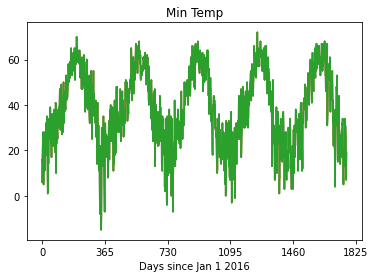

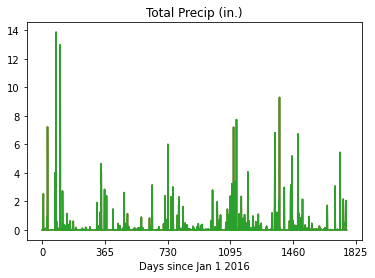

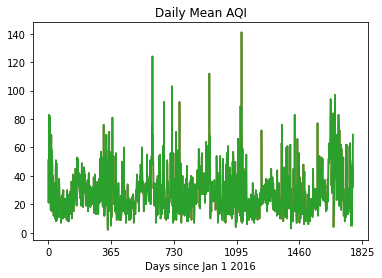

In [15]:
for i in np.arange(0,np.shape(data)[1]):  
  plt.plot(data[:,0]); 
plt.title(included_cols[0]) 
plt.xlabel('Days since Jan 1 2016') 
plt.xticks(ticks = np.arange(0, len(data)+365, 365)) 
plt.show()

for i in np.arange(0,np.shape(data)[1]):  
  plt.plot(data[:,1]); 
plt.title(included_cols[1]) 
plt.xlabel('Days since Jan 1 2016') 
plt.xticks(ticks = np.arange(0, len(data)+365, 365)) 
plt.show()

for i in np.arange(0,np.shape(data)[1]):  
  plt.plot(data[:,2]); 
plt.title(included_cols[2]) 
plt.xlabel('Days since Jan 1 2016') 
plt.xticks(ticks = np.arange(0, len(data)+365, 365)) 
plt.show()

In [16]:
scaled_data = whiten(data)

print(np.mean(scaled_data,axis=0))

print(np.std(scaled_data,axis=0))

[2.30059766 0.19325204 1.832819  ]
[1. 1. 1.]


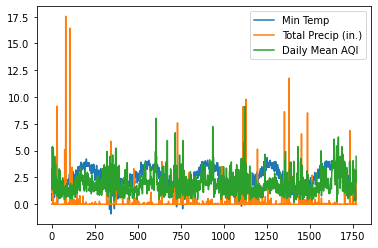

In [17]:
quickplot = 'yes'
if quickplot == 'yes':
## Quick plots of data
  for i in np.arange(0,np.shape(scaled_data)[1]):
    plt.plot(scaled_data[:,i],label=included_cols[i]);

plt.legend()

In [18]:
## select the number of clusters
NO_CLUSTERS = 4 # use 4 clusters to see if there is a winter, fall, spring, and summer in Denver, CO.
## do the clustering, return centroids
centroids, _ = kmeans(scaled_data,NO_CLUSTERS,iter=20)

In [19]:
## find an index (idx) - label for each value in the dataset
idx, _ = vq(scaled_data,centroids) # vq returns cluster idx for each observation
## add 1 so that idx is also 1-based like df['season']
idx=idx+1
print('Here is the cluster idx for each day of the year:')
print(idx.shape) # prints K-mean's season label for each day

Here is the cluster idx for each day of the year:
(1771,)


###**Step 4: Present results visually using 2-3 graphs**

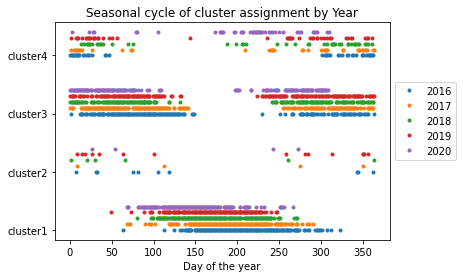

In [20]:
### quick plot to show index results
### plot each year
plt.plot(idx[0:365],'.',label='2016');
plt.plot(idx[365:365*2]+0.1,'.',label='2017');
plt.plot(idx[365*2:365*3]+0.2,'.',label='2018');
plt.plot(idx[365*3:365*4]+0.3,'.',label='2019');
plt.plot(idx[365*4:365*5]+0.4,'.',label='2020');
#plt.legend(loc='best');
plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
plt.yticks(np.arange(1,NO_CLUSTERS+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.xlabel('Day of the year')
plt.title('Seasonal cycle of cluster assignment by Year');

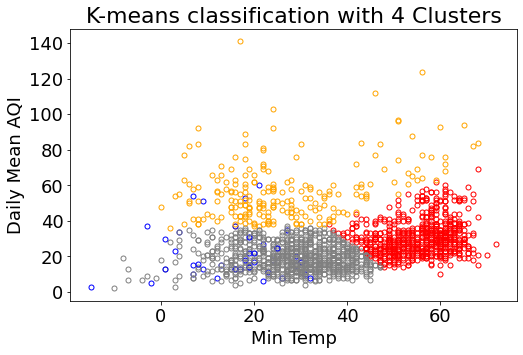

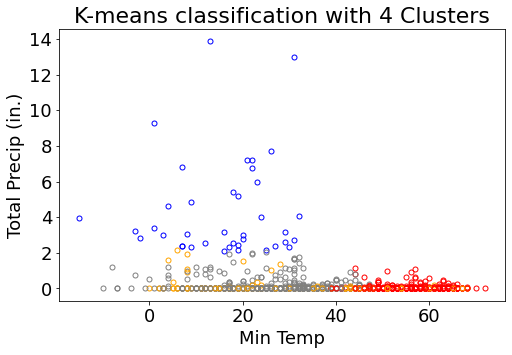

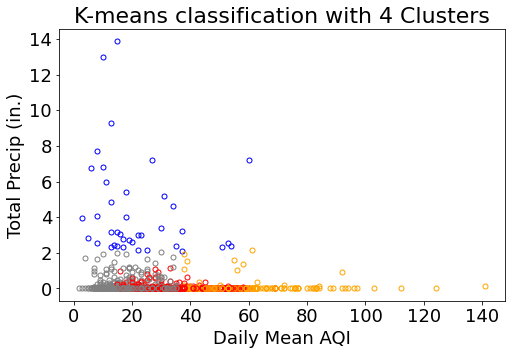

In [21]:
## Create a few xy scatter plots, where points are colored by "season"
### Pick two variables that are part of included_cols

##### PLOT #1
### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['Min Temp','Daily Mean AQI']
data2plot = [data[:,included_cols.index(var)] for var in vars2plot]
## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx2plot[i]=included_cols.index(vars2plot[i])
### Next plot variables as the original values with colors to identify associated cluster
# (red=1, blue=2, grey=3, orange=4)
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
  plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);
plt.show()

##### PLOT #2
### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['Min Temp','Total Precip (in.)']
data2plot = [data[:,included_cols.index(var)] for var in vars2plot]
## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx2plot[i]=included_cols.index(vars2plot[i])
### Next plot variables as the original values with colors to identify the associated cluster
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
  plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);
plt.show()

##### PLOT #3
### select two variables and put them in vars2plot - # format (x, y)
vars2plot = ['Daily Mean AQI','Total Precip (in.)']
data2plot = [data[:,included_cols.index(var)] for var in vars2plot]
## find the integer index of the variable to plot
varidx2plot=np.zeros(2,dtype="int")
for i in np.arange(0,2):
  varidx2plot[i]=included_cols.index(vars2plot[i])
### Next plot variables as the original values with colors to identify the associated cluster
cols = ['','red','blue','grey','orange']
plt.figure(figsize=(8,5))
plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
for (ind,val) in enumerate(np.transpose(data2plot)):
  plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(vars2plot[0],fontsize=18);
plt.ylabel(vars2plot[1],fontsize=18);
plt.show()

In [22]:
#### prepare data to plot in the histograms
## this is the actual season from the definition in the season dictionary above
season_idx=df['season'].to_numpy()
print(season_idx.shape)
## this is the season from the k-means clustering algorithm
print(idx.shape)
### find what the k-means clustering assigned in each season
## find all of the days in winter, i.e., where season_idx=1
winteridx=np.nonzero(np.where(season_idx==1,1,0))
#print(winteridx) ### uncomment me to check the code
## find what values the k-means classified for this season
winter=idx[winteridx]
#print(winter) ### uncomment me to check the code
## find all of the days in spring, i.e., where season_idx=2
springidx=np.nonzero(np.where(season_idx==2,1,0))
## find what values the k-means classified for this season
spring=idx[springidx]
## find all of the days in summer, i.e., where season_idx=3
summeridx=np.nonzero(np.where(season_idx==3,1,0))
## find what values the k-means classified for this season
summer=idx[summeridx]
## find all of the days in fall, i.e., where season_idx=4
fallidx=np.nonzero(np.where(season_idx==4,1,0))
## find what values the k-means classified for this season
fall=idx[fallidx]

(1771,)
(1771,)


[0.5 1.5 2.5 3.5 4.5]


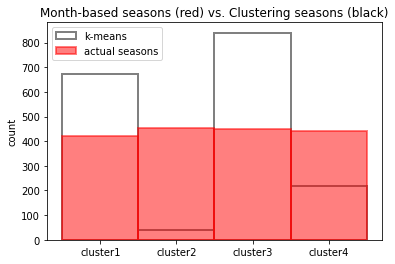

In [23]:
### Histogram Type #1 - Compare seasons based on month and k-means clustering over entire year
## define bins for the histogram
delta= 1 ## bin size
minbin= 0.5 ## minimum bin value
maxbin= 5.5 ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
print(hist_bins) ## print histograms to check
#### all data - plot histogram
h, mids = np.histogram(idx,bins=hist_bins);
plt.hist(idx,bins=mids,facecolor='white',edgecolor="grey",label='k-means',lw=2);
plt.hist(season_idx,bins=mids,facecolor='r',edgecolor="r",label='actual seasons',alpha=0.5,lw=2);
plt.ylabel('count')
#plt.ylim(0,1000)
plt.xticks(np.arange(1,4+1),labels=['cluster1','cluster2','cluster3','cluster4']);
plt.legend();
plt.title('Month-based seasons (red) vs. Clustering seasons (black)');

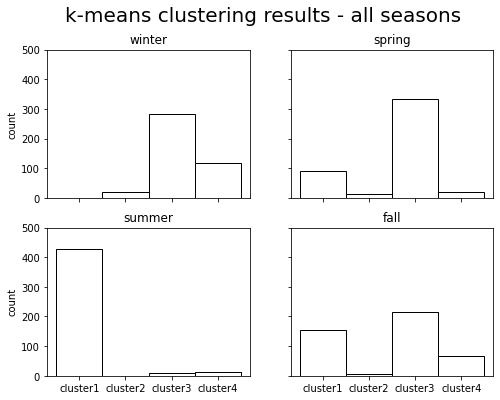

In [24]:
### Histogram Type #2 - Histograms of seasons based on k-means clustering for each season

## define bins for the histogram
delta= 1 ## bin size
minbin= 0.5 ## minimum bin value
maxbin= 5.5 ## maximum bin value
hist_bins = np.arange(minbin,maxbin,delta) ## bins
#print(hist_bins) ## print your histograms to check them
## sanity check = plot the histogram of assigned clusters for winter
#h, mids = np.histogram(winter,bins=hist_bins);
#labels4xaxis=['cluster1','cluster2','cluster3','cluster4']
#plt.figure(figsize=(4,4))
#plt.hist(winter,bins=mids,facecolor='w',edgecolor="k");
#plt.xticks(np.arange(1,4+1),labels=labels4xaxis);
#plt.title('Winter');
#plt.show();
### Show all seasons using subplots
labels4xaxis=['','cluster1','cluster2','cluster3','cluster4']
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.suptitle('k-means clustering results - all seasons',fontsize=20)
fig.set_figheight(6)
fig.set_figwidth(8)
ymax=500
h, mids = np.histogram(winter,bins=hist_bins);
ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
ax1.set_title("winter");
ax1.set_ylabel("count");
ax1.set_ylim(0,ymax)
h, mids = np.histogram(spring,bins=hist_bins);
ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
ax2.set_title("spring");
ax2.set_ylim(0,ymax)
h, mids = np.histogram(summer,bins=hist_bins);
ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
ax3.set_title("summer");
ax3.set_xticklabels(labels4xaxis);
ax3.set_ylabel("count");
ax3.set_ylim(0,ymax)
h, mids = np.histogram(fall,bins=hist_bins);
ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
ax4.set_title("fall");
ax4.set_xticklabels(labels4xaxis);
ax4.set_ylim(0,ymax)
for ax in fig.get_axes():
  ax.label_outer()

###**Summary**: Write your text here. Discuss what you found including how it relates to your hypothesis and underlying motivation.

This project's aim was to determine if daily mean AQI measurements can be factored into a cluster analysis for seasons in Denver, CO. According to my complete cluster analysis using the variables 'total precip. (in)', 'min temp (F)' and 'daily mean AQI' for the Denver Int'l Airport area between 2016 and 2020, daily mean AQI does not seem to be a seasonally-variable enough factor to use in order to cluster seasons. I would've liked to use the 'max temp (F)' variable as well, but I was unable to determine why that particular column of data broke the code any time I tried to perform any data analysis on it; I believe, however, that it may have been able to help offer a better picture of how seasons vary in Denver, CO. Overall, it appears that an analysis utilizing daily mean AQI shows that Denver, CO only strongly exhibits one season (summer, cluster 1), a strange, partial winter/fall/spring season (cluster 3), and a small and sporadic transtionary season, given by cluster 4. Cluster 2 does not appear to fit well into any season, making it primarily negligible. In summary, in accordance with this project's results, daily mean AQI does not have a strong or consistent enough variability pattern across seasons in order to factor it into a cluster analysis. I believe, however, that if I were to factor in snowfall and precip. separately as well as max temp, this cluster analysis could improve in accuracy, regardless of using daily mean AQI as a variable. 